# Support Vector Machines

## 1 - Packages ##

In [0]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

cvxopt.solvers.options['show_progress'] = False

## 2 - Overview of the Dataset  ##

**Problem Statement**: given a dataset of 23 species of gilled mushrooms. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility (combined with the poisonous one). The data containing:
    - a training set of m_train examples
    - a test set of m_test examples
    - each example is of shape (number of features, 1)

In [0]:
def load_data():
    from sklearn.model_selection import train_test_split
    
    X = np.genfromtxt('mush_features.csv')
    Y = np.genfromtxt('mush_labels.csv')
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, Y, test_size=0.33, random_state=42)
    
    train_set_x = train_set_x[:300].astype(float)
    train_set_y = train_set_y[:300].astype(float)
    
    test_set_x = test_set_x[:100].astype(float)
    test_set_y = test_set_y[:100].astype(float)
    
    x_test = train_set_x[:5]
    y_test = train_set_y[:5]   
    
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    x_test = x_test.reshape(x_test.shape[0], -1).T
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test

Checking shapes:

In [0]:
train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test = load_data()
print('train_set_x.shape: ', train_set_x.shape)
print('test_set_x.shape: ', test_set_x.shape)
print('train_set_y.shape: ', train_set_y.shape)
print('test_set_y.shape: ', test_set_y.shape)

train_set_x.shape:  (22, 300)
test_set_x.shape:  (22, 100)
train_set_y.shape:  (1, 300)
test_set_y.shape:  (1, 100)


Distribution of samples in train set:

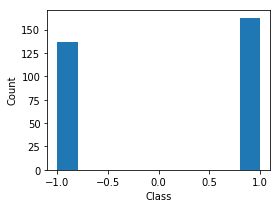

In [0]:
plt.figure(figsize=(4, 3))
plt.hist(train_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Distribution of samples in test set:

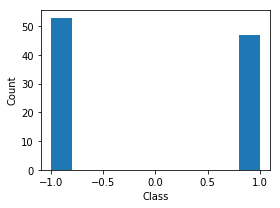

In [0]:
plt.figure(figsize=(4, 3))
plt.hist(test_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 3 - General Architecture of the learning algorithm ##

The SVM algorithm is implemented using a kernel. For making a prediction for a new input we using the dot product as follows: 

$$f(x) = sign(b + \sum_{s \in S}(a_s * k(x, x_s)))$$

### 3.1 - Kernels###




#### Linear Kernel

$$k(x_{i},x _{j}) = x_{i}x_{j}\tag{1}$$


#### Polynomial Kernel SVM ####

$$k(x_{i},x _{j}) = (x_{i}x_{j} + coef)^{d}\tag{2}$$


#### Gaussian kernel ####

$$k(x_{i}, x_{j})=exp(-\frac{\left \| x_i-x_j \right \|^2}{2\sigma^2})\tag{3}$$

#### Gaussian radial basis function (RBF) ####
$$k(x_{i}, x_{j})=exp(-\gamma {\left \| x_i-x_j \right \|^2})\tag{4}$$

Implement these kernel functions in the cell below:

In [1]:
# Kernels

class Kernel(object):
    def linear():
        return lambda x, y: np.dot(x,y)
    
    def gaussian(sigma):
        return lambda x, y: np.exp(-0.5*(np.linalg.norm(x-y)/sigma)**2)
        
    def polynomial(coef, power):
        return lambda x, y: (np.dot(x,y)+coef)**power
        
    def rbf(gamma):
        return lambda x, y: np.exp(-gamma*np.linalg.norm(x-y)**2)

In [0]:
lin = Kernel.linear()
gauss = Kernel.gaussian(4)
polynom = Kernel.polynomial(3, 2)
rbf = Kernel.rbf(0.0002)

xt = x_test[:, 1]
yt = x_test[:, 2]

print('linear_kernel: ', lin(xt, yt))
print('polynomial_kernel: ', polynom(xt, yt))
print('gaussian_kernel: ', gauss(xt, yt))
print('rbf_kernel: ', rbf(xt, yt))

linear_kernel:  202.0
polynomial_kernel:  42025.0
gaussian_kernel:  0.23021307174736147
rbf_kernel:  0.9906440418940348


### 3.2 Model

1. `_kernel_matrix` - calculate kernel matrix
2. `_compute_lagrange_multipliers` - solve a quadratic optimization problem and compute lagrange multipliers
3. `_get_support_vectors` - extract support vectors
4. `fit` - compute b and lagrange multipliers
5. `predict` - use trained by `fit` params to make predictions: $f(x) = sign(b + \sum_{s \in S}(a_s * y_s*k(x, x_s)))$

In [2]:
class SVM(object):

    def __init__(self, C=1, kernel=Kernel.linear()):
        self.C = C
        self.kernel = kernel
        self.non_zero_multipliers = None
        self.support_vectors = None
        self.support_labels = None
        self.b = None
    
    def _pairwise_matrix(self, X, operation):
        
        def calc(x, mu):
            assert(x.shape == mu.shape)
            return operation(x,mu)

        def iter_over(X, X_i):
            assert(X.shape[1] == X_i.shape[0])
            return np.vectorize(calc, signature='(m),(s)->()')(X, X_i)

        return np.vectorize(iter_over, signature='(m,n),(s)->(k)')(X, X)

    
    def _kernel_matrix(self, X):
    
        # Get number of samples
        n_samples = X.shape[0]
        
        # Calculate kernels pairwise and fill kernels matrix
        K = self._pairwise_matrix(X.T, self.kernel)

        # Return kernel matrix
        return K

    def _compute_lagrange_multipliers(self, X, Y):
        
        # Get number of samples
        n_samples = np.size(Y)
        
        # Get Kernel matrix by calling _kernel_matrix function
        K = self._kernel_matrix(X)

        # Create create quadratic term P based on Kernel matrix
        Y_i, Y_j = np.meshgrid(Y, Y)
        P = cvxopt.matrix(Y_i*Y_j*K)
        
        # Create linear term q
        q = cvxopt.matrix(np.zeros(n_samples)-1)

        # Create G, h
        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        # Create A, b
        A = cvxopt.matrix(Y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        # Solve the quadratic optimization problem using cvxopt
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Extract flat array of lagrange multipliers
        lagrange_multipliers = np.ravel(solution['x'])

        # Return lagrange multipliers
        return lagrange_multipliers

    def _get_support_vectors(self, lagrange_multipliers, X, Y):
        
        # Get indexes of non-zero lagrange multipiers
        idx = lagrange_multipliers > 1e-7
        
        # Get the corresponding lagrange multipliers
        non_zero_multipliers = lagrange_multipliers[idx]
        
        # Get the samples that will act as support vectors
        support_vectors = X[:,idx]
        
        # Get the corresponding labels
        support_labels = Y[:,idx]
        
        # Return 
        return non_zero_multipliers, support_vectors, support_labels

    def fit(self, X, Y):
        
        # Solve the quadratic optimization problem and get lagrange multipliers
        lagrange_multipliers = self._compute_lagrange_multipliers(X,Y)

        # Extract support vectors and non zero lagrange multipliers
        self.non_zero_multipliers, self.support_vectors, self.support_labels = \
            self._get_support_vectors(lagrange_multipliers, X, Y)
        
        # Calculate b using first support vector
        
        kernels = \
        np.vectorize(self.kernel, signature='(m),(s)->()')(self.support_vectors.T, self.support_vectors.T[0])
        self.b = self.support_labels.ravel()[0] - \
            np.dot(self.non_zero_multipliers * self.support_labels.ravel(), kernels)
        
    def predict(self, X):
        
        n_samples = X.shape[1]
        
        def iter_over(sample):
            kernels = np.vectorize(self.kernel, signature='(m),(s)->()')(self.support_vectors.T, sample)
            return np.dot(self.non_zero_multipliers * self.support_labels.ravel(), kernels) + self.b
        
        predictions = np.sign(np.vectorize(iter_over, signature='(s)->()')(X.T))
        
        return predictions.reshape(1,n_samples)
    

In [0]:
model = SVM(C=2)

In [0]:
k = model._kernel_matrix(x_test)
print('kernel matrix:')
print(k)

kernel matrix:
[[240. 231. 190. 145. 180.]
 [231. 248. 202. 152. 201.]
 [190. 202. 203. 135. 197.]
 [145. 152. 135. 109. 129.]
 [180. 201. 197. 129. 255.]]


In [0]:
lm = model._compute_lagrange_multipliers(x_test, y_test)
print('lagrange multipliers: ')
print(lm)

lagrange multipliers: 
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]


In [0]:
nzl, sv, sl = model._get_support_vectors(lm, x_test,y_test)
print('non-zero lagrange multipliers:')
print(nzl)
print('support vectors:')
print(sv)
print('support labels:')
print(sl)


non-zero lagrange multipliers:
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]
support vectors:
[[5. 5. 2. 2. 2.]
 [3. 3. 2. 0. 3.]
 [4. 2. 4. 3. 2.]
 [1. 1. 0. 0. 0.]
 [5. 5. 5. 2. 7.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [7. 5. 4. 3. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 3. 1. 0.]
 [2. 2. 2. 1. 1.]
 [2. 2. 0. 1. 1.]
 [7. 7. 7. 6. 7.]
 [3. 7. 7. 4. 7.]
 [0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]
 [4. 4. 0. 2. 0.]
 [3. 2. 3. 1. 7.]
 [4. 5. 3. 4. 4.]
 [0. 0. 1. 1. 4.]]
support labels:
[[-1. -1. -1.  1.  1.]]


In [0]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels, axis=1) / float(labels.shape[1])

## 4 - Training

In [0]:
clf = SVM(C=1, kernel=Kernel.linear())

In [0]:
clf.fit(train_set_x, train_set_y)

## 5 - Making predictions

In [0]:
y_pred = clf.predict(test_set_x)

In [0]:
accuracy(y_pred, test_set_y)

array([0.99])

## 6 - Visualization

Generate simple data to see how types of kernel affects the decision boundary.

In [0]:
samples = np.random.normal(size=200).reshape(2, 100)
labels = (2 * (samples.sum(axis=0) > 0) - 1.0).reshape(1, 100)

In [0]:
def plot(model, X, Y, grid_size):
    
    import matplotlib.cm as cm
    import itertools
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []

    model.fit(X, Y)
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([[xx[i, j]], [yy[i, j]]])
        result.append(model.predict(point)[0, 0])

    print(np.array(result).shape)
    print(xx.shape)
    
    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.7
    )
    
    
    plt.scatter(
        flatten(X[0, :]),
        flatten(X[1, :]),
        c=flatten(Y),
        cmap=cm.Paired,
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

#### Linear Kernel

(40000,)
(200, 200)


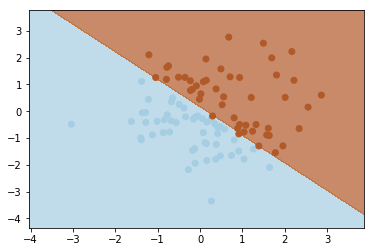

In [0]:
clf_lin = SVM(C=1, kernel=Kernel.linear())
plot(clf_lin, samples, labels, 200)

#### Gaussian Kernel

(40000,)
(200, 200)


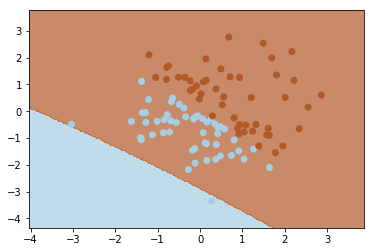

In [0]:
clf_gaussian = SVM(C=1, kernel=Kernel.gaussian(14))
plot(clf_gaussian, samples, labels, 200)

#### Polynomial Kernel

(40000,)
(200, 200)


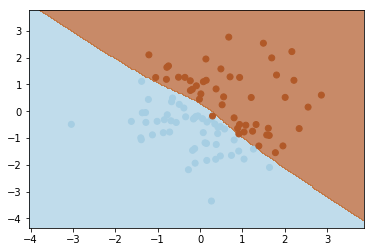

In [0]:
clf_polynomial = SVM(C=1, kernel=Kernel.polynomial(1, 3))
plot(clf_polynomial, samples, labels, 200)

#### RBF

(40000,)
(200, 200)


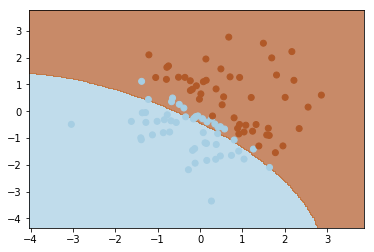

In [0]:
clf_rbf = SVM(C=1, kernel=Kernel.rbf(0.03))
plot(clf_rbf, samples, labels, 200)